# Custom Transformer

In [255]:
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import set_config; set_config(display='diagram')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate


👇 Consider the following dataset

In [206]:
data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/08-Workflow/custom_transformer_data.csv")
data.head()

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery
0,RJ,SP,1825,53,10,40,9
1,RJ,SP,700,65,18,28,9
2,RJ,SP,1825,53,10,40,11
3,RJ,SP,1825,53,10,40,12
4,RJ,SP,1825,53,10,40,14


- Each observation of the dataset represents an item being delivered from a  `seller_state` to a `customer_state`. 
- Other columns describe the packaging properties of each item.

🎯 The target is the number of days between the order and the delivery.

In [207]:
data.shape

(1000, 7)

In [208]:
np.log(1000)

6.907755278982137

<AxesSubplot:xlabel='days_until_delivery', ylabel='Count'>

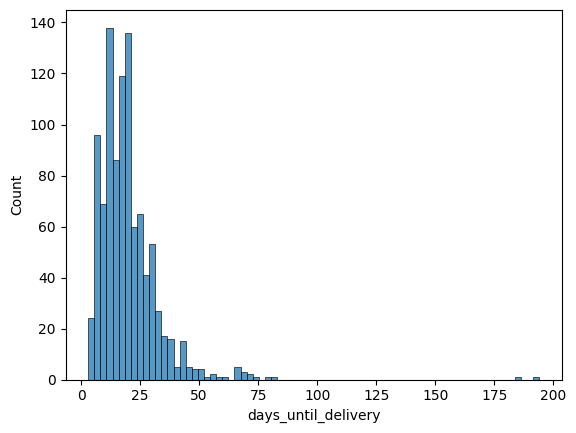

In [209]:
# Check target
sns.histplot(data.days_until_delivery)

In [210]:
X = data.drop("days_until_delivery", axis=1)

y = data["days_until_delivery"]


## 1. Pipeline

👇 Create a scikit-learn pipeline named `pipe`:

- Engineer a `volume` feature from the dimensions features
- Preserve the original product dimensions features for training
- Scale all numerical features
- Encode the categorical features
- Add a default `Ridge` regression estimator

**Note:** for this challenge, ignore the holdout method, so no need to `train_test_split`!

<details><summary>Hints</summary>

- There are many ways to create your preprocessed matrix (using `ColumnTransformer` and/or `FeatureUnion`). 
    
- If your transformed feature matrix look weird, it may be stored as "sparse" by the default behavior of `OneHotEncoder(sparse_output=True)`. Use `.todense()` to turn it back to a dense matrix

</details>

In [211]:
data.dtypes

customer_state         object
seller_state           object
product_weight_g        int64
product_length_cm       int64
product_height_cm       int64
product_width_cm        int64
days_until_delivery     int64
dtype: object

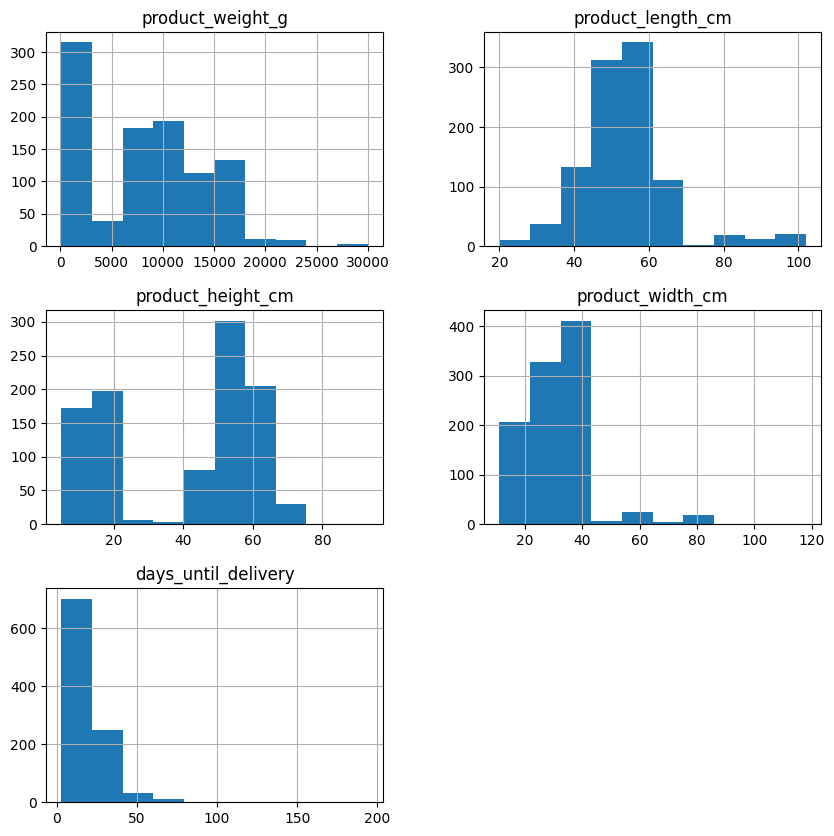

In [212]:
from matplotlib import pyplot as plt

data.hist(figsize=(10,10))
plt.show()

<AxesSubplot:>

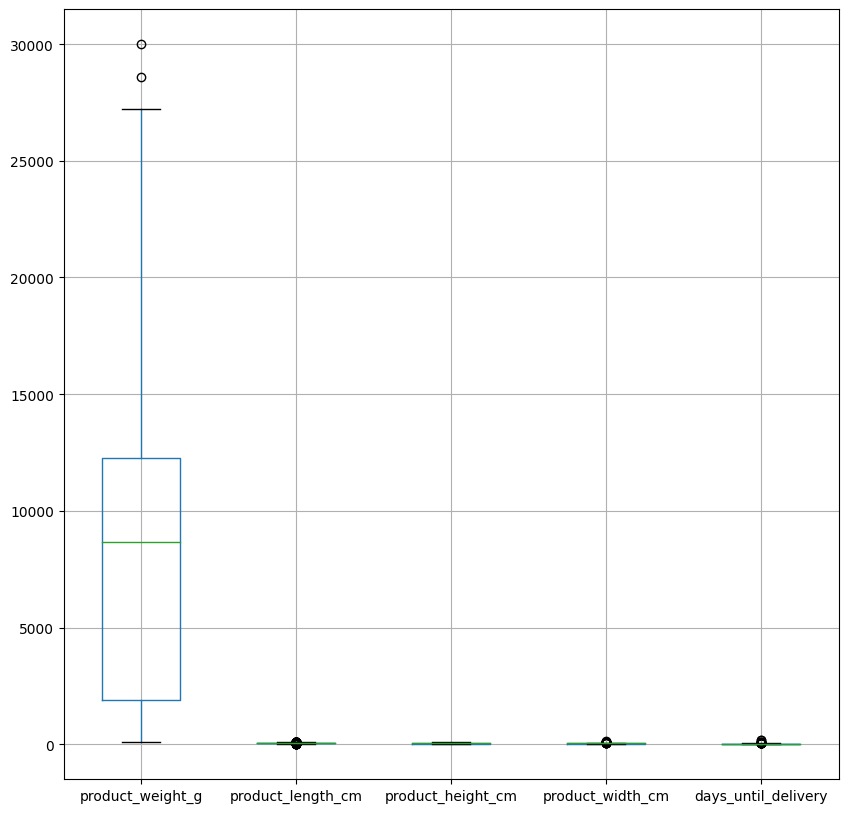

In [213]:
data.boxplot(figsize=(10,10))


### Numerical pipeline

In [214]:
numerical = data.select_dtypes(include="number")
numerical.head(1)

,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery
0,1825,53,10,40,9


In [215]:
numerical.isnull().sum()

product_weight_g       0
product_length_cm      0
product_height_cm      0
product_width_cm       0
days_until_delivery    0
dtype: int64

In [219]:
# Create new column

volume = FunctionTransformer(
    lambda df: pd.DataFrame(
        df["product_length_cm"] / df["product_width_cm"] * df["product_height_cm"]
    )
)

union = FeatureUnion(
    [
        ("volume", volume),
    ]
).set_output(transform="pands")

union

In [238]:
def calculate_volume(df):
    df["volume"] = df["product_length_cm"] * df["product_width_cm"] * df["product_height_cm"]
    return df

In [239]:
volume = FunctionTransformer(calculate_volume
)

In [240]:
# Build numerical pipeline
# Scaling
num_preprocessing = Pipeline([
    ('add_column', volume),
    ('robust_scaler', RobustScaler())
]).set_output(transform="pandas")

num_preprocessing

Pipeline(steps=[('add_column',
                 FunctionTransformer(func=<function calculate_volume at 0x7f465541dfc0>)),
                ('robust_scaler', RobustScaler())])

In [242]:
num_preprocessing.fit(X.select_dtypes("number"))
test = num_preprocessing.transform(X.select_dtypes("number"))
test

,product_weight_g,product_length_cm,product_height_cm,product_width_cm,volume
0,-0.660217,0.000000,-1.000000,0.642857,-0.556110
1,-0.768520,1.000000,-0.804878,-0.214286,-0.344725
2,-0.660217,0.000000,-1.000000,0.642857,-0.556110
3,-0.660217,0.000000,-1.000000,0.642857,-0.556110
4,-0.660217,0.000000,-1.000000,0.642857,-0.556110
...,...,...,...,...,...
995,0.781420,0.833333,0.170732,-0.500000,0.659828
996,-0.770927,-1.083333,-0.804878,0.285714,-0.482967
997,-0.638556,-0.666667,-0.878049,0.285714,-0.511767
998,0.006450,-0.083333,0.000000,-1.000000,-0.119370


### Categorical pipeline 

In [243]:
categorical = data.select_dtypes(exclude="number")
for c in categorical:
    print("Unique values:", categorical[c].nunique())
    display(categorical[c].value_counts())

Unique values: 25


SP    409
RJ    170
MG     99
BA     51
RS     49
PR     45
SC     27
ES     22
GO     17
PA     16
CE     14
DF     13
PE     13
MT     12
PB     10
MA      9
AL      5
MS      4
PI      4
RN      4
SE      3
AM      1
TO      1
RO      1
AP      1
Name: customer_state, dtype: int64

Unique values: 2


SP    988
SC     12
Name: seller_state, dtype: int64

In [244]:
# Build categorical pipeline
# Encoding
cat_preprocessing = Pipeline([
    ('ohe', OneHotEncoder(drop=None, sparse_output=False, handle_unknown="ignore"))
]).set_output(transform="pandas")

cat_preprocessing

Pipeline(steps=[('ohe',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [245]:
test_ohe = cat_preprocessing.fit(X.select_dtypes(exclude="number"))
test_ohe = cat_preprocessing.transform(X.select_dtypes(exclude="number"))

print(X.select_dtypes(include="number").shape)

print(test_ohe.shape)
test_ohe.head(1)

(1000, 4)
(1000, 27)


,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,customer_state_DF,customer_state_ES,customer_state_GO,customer_state_MA,customer_state_MG,...,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,seller_state_SC,seller_state_SP
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [246]:
col_transform = ColumnTransformer([
    ("num_transform", num_preprocessing, make_column_selector(dtype_include="number")),
    ("cat_transform", cat_preprocessing, make_column_selector(dtype_exclude="number"))
], remainder="passthrough").set_output(transform="pandas")

col_transform

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_transform',
                                 Pipeline(steps=[('add_column',
                                                  FunctionTransformer(func=<function calculate_volume at 0x7f465541dfc0>)),
                                                 ('robust_scaler',
                                                  RobustScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f465540b490>),
                                ('cat_transform',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f46554099f0>)])

In [247]:
test_ohe = col_transform.fit(X)
test_ohe = col_transform.transform(X)

print(X.select_dtypes(include="number").shape)

print(test_ohe.shape)
test_ohe.head(1)

(1000, 4)
(1000, 32)


,num_transform__product_weight_g,num_transform__product_length_cm,num_transform__product_height_cm,num_transform__product_width_cm,num_transform__volume,cat_transform__customer_state_AL,cat_transform__customer_state_AM,cat_transform__customer_state_AP,cat_transform__customer_state_BA,cat_transform__customer_state_CE,...,cat_transform__customer_state_RJ,cat_transform__customer_state_RN,cat_transform__customer_state_RO,cat_transform__customer_state_RS,cat_transform__customer_state_SC,cat_transform__customer_state_SE,cat_transform__customer_state_SP,cat_transform__customer_state_TO,cat_transform__seller_state_SC,cat_transform__seller_state_SP
0,-0.660217,0.0,-1.0,0.642857,-0.55611,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [248]:
pipe = Pipeline([
    ("clean_data", col_transform),
    ("linreg", Ridge())
])

pipe

Pipeline(steps=[('clean_data',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transform',
                                                  Pipeline(steps=[('add_column',
                                                                   FunctionTransformer(func=<function calculate_volume at 0x7f465541dfc0>)),
                                                                  ('robust_scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f465540b490>),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f46554099f0>)])),
                ('linreg', Ridge())])

In [249]:
pipe.fit(X, y)

Pipeline(steps=[('clean_data',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transform',
                                                  Pipeline(steps=[('add_column',
                                                                   FunctionTransformer(func=<function calculate_volume at 0x7f465541dfc0>)),
                                                                  ('robust_scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f465540b490>),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f46554099f0>)])),
                ('linreg', Ridge())])

In [250]:
pipe.score(X, y)

0.255533424195617

#### 🧪 Test your pipe

In [251]:
from nbresult import ChallengeResult

pipe_test = pipe

# Check that it doesn't crash
assert pipe_test.fit(X, y)

result = ChallengeResult(
    'pipe',
    shape = pipe_test[:-1].fit_transform(X).shape
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/branchedelac/.pyenv/versions/3.10.6/envs/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/branchedelac/code/branchedelac/05-ML/08-Workflow/data-custom-transformer/tests
plugins: anyio-3.6.2, asyncio-0.19.0, typeguard-2.13.3
asyncio: mode=strict
collecting ... collected 1 item

test_pipe.py::TestPipe::test_pipe_not_crashing PASSED                    [100%]

============================== 1 passed in 0.74s ===============================


💯 You can commit your code:

git add tests/pipe.pickle

git commit -m 'Completed pipe step'

git push origin master



## 2. Train and Predict

👇 Let's imagine `data` is your entire training set.

- `cross_validate` your pipeline on this dataset (❗️low r2 score are expected)
- Now, imagine you just received an new order `new_data`: predict it's duration of delivery in a variable `prediction`

In [252]:
new_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/08-Workflow/custom_transformer_new_order.csv")
new_data

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,RJ,SP,1825,53,10,40


In [259]:
cv_results = pd.DataFrame(cross_validate(estimator=pipe, X=X, y=y))
cv_results

,fit_time,score_time,test_score
0,0.065704,0.024272,0.139642
1,0.043596,0.026777,0.129100
2,0.057951,0.020674,0.109403
3,0.053364,0.025527,0.012487
4,0.047037,0.022123,0.233011


In [263]:
pipe.fit(X, y)
prediction = pipe.predict(new_data)
prediction

array([20.69440244])

In [264]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'prediction',
    prediction = prediction
)

result.write()
print(result.check())



============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/branchedelac/.pyenv/versions/3.10.6/envs/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/branchedelac/code/branchedelac/05-ML/08-Workflow/data-custom-transformer/tests
plugins: anyio-3.6.2, asyncio-0.19.0, typeguard-2.13.3
asyncio: mode=strict
collecting ... collected 1 item

test_prediction.py::TestPrediction::test_prediction PASSED               [100%]

============================== 1 passed in 0.54s ===============================


💯 You can commit your code:

git add tests/prediction.pickle

git commit -m 'Completed prediction step'

git push origin master



🏁 Congratulation. Don't forget to add, commit and push your notebook.